Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import numpy as np
import datetime as dt

%matplotlib inline

In [67]:
dataset = pd.read_csv('data/aac_shelter_outcomes.csv')
dataset.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [68]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 3.6+ MB


Всего в датасете 78256 записей. Предположительно наблюдей достаточно для построения модели. 

Есть пропущенные значения в полях: age_upon_outcome, name, outcome_subtype, outcome_type, outcome_type, sex_upon_outcome. Наибольшее количество пропусков в name и outcome_subtype.

На текущий момент все признаки являются категориальными с типом object. Требуетя работа с признаками по отдельности и преобразование. 

In [69]:
dataset.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78244,78254
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,9,5
top,1 year,A718223,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784


Посмотрим каждый столбец и попробуем преобразовать признаки.

### animal_id

In [70]:
dataset.animal_id.value_counts()

A718223    11
A706536    11
A721033    10
A694501     8
A616444     8
           ..
A735327     1
A752401     1
A760342     1
A739547     1
A693321     1
Name: animal_id, Length: 70855, dtype: int64

AnimalID представляет уникальный индентификатор животного и, очевидно, не влияет на вероятный исход. 

Удалим этот признак. 

In [71]:
dataset = dataset.drop('animal_id', axis=1)

### Визуально складывается ощущение, что столбцы datetime и monthyear имеют одинаковое значение. Проверим эту гипотезу.

In [72]:
dataset['datasetates_check'] = dataset.datetime == dataset.monthyear

In [73]:
dataset.datasetates_check.value_counts()

True    78256
Name: datasetates_check, dtype: int64

Признаки абсолютно идентичны, удалим признак monthyear, а также технический признак datasetates_check.

In [74]:
dataset = dataset.drop(['monthyear','datasetates_check'], axis=1)

### age_upon_outcome

In [75]:
dataset.age_upon_outcome.value_counts()

1 year       14355
2 years      11194
2 months      9213
3 years       5157
3 months      3442
1 month       3344
4 years       2990
5 years       2691
4 months      2425
5 months      1951
6 months      1897
6 years       1810
8 years       1554
7 years       1537
3 weeks       1467
2 weeks       1330
10 months     1204
4 weeks       1194
8 months      1178
10 years      1159
7 months       963
9 years        822
9 months       673
12 years       609
1 weeks        513
11 months      490
11 years       429
1 week         427
13 years       389
14 years       253
3 days         235
2 days         217
15 years       208
1 day          153
6 days         152
4 days         136
5 days         116
16 years       101
0 years         95
5 weeks         61
17 years        58
18 years        26
19 years        13
20 years        12
22 years         4
25 years         1
Name: age_upon_outcome, dtype: int64

Есть много разных значения, причем можно выделить разновидности - дни, недели, месяцы, годы. 

В идеале все привести к какому-то одному значению, возможно в годах. Чтобы это сделать необходимо сначала все пересчитать в количество дней, а затем поделить на 365. 

In [76]:
dataset['value'] = dataset.age_upon_outcome.str.split(' ').str[0].fillna(0).astype(int)
dataset['category'] = dataset.age_upon_outcome.str.split(' ').str[1].fillna(0)

In [77]:
dataset['category'].unique()

array(['weeks', 'year', 'years', 'months', 'month', 'days', 'week', 'day',
       0], dtype=object)

In [78]:
dataset['category'] =   np.where(dataset['category'].str.contains('day'), 1, 
                        np.where(dataset['category'].str.contains('week'), 7, 
                        np.where(dataset['category'].str.contains('month'), 30, 
                        np.where(dataset['category'].str.contains('year'), 365, 0)))).astype(int)

dataset['outcome_age_(days)'] = dataset['category'] * dataset['value']
dataset['outcome_age_(years)'] = dataset['outcome_age_(days)'] / 365

In [79]:
dataset = dataset.drop(['age_upon_outcome','value','category','outcome_age_(days)'], axis=1)

In [80]:
dataset['outcome_age_(years)'].count()

78256

In [81]:
dataset['outcome_age_(years)'].value_counts().count()

45

На 78 256 записей получается 45 уникальных записей о возврасте. Далее преобразования не производим. 

Предположим, что помимо самого показателя возраста особо влияение оказывает молодость (щенки, котята до 0,5 года) или наоборот старший возраст (более 10 лет). Так как не решать планируем при помощи дерева решений, то oh_encoding не применяем, только определяем категории. 

In [82]:
dataset['old/young'] =  np.where(dataset['outcome_age_(years)'] <= 0.5, 'young', 
                        np.where(dataset['outcome_age_(years)'] <= 5, 'medium',
                        np.where(dataset['outcome_age_(years)'] <= 10, 'old', 'very_old')))

In [83]:
dataset['old/young'].value_counts()

medium      40895
young       28376
old          6882
very_old     2103
Name: old/young, dtype: int64

### name

In [84]:
dataset['name'] = dataset['name'].str.strip('*')

In [85]:
dataset.name.value_counts()

Max            367
Bella          367
Charlie        291
Daisy          285
Luna           274
              ... 
Jamilla Kim      1
Abrams           1
White Girl       1
Brina            1
Bernabe          1
Name: name, Length: 11790, dtype: int64

In [86]:
names_freq_df = dataset.name.value_counts().rename_axis('unique_values').reset_index(name='name_freq')

In [87]:
names_freq_df

,unique_values,name_freq
0,Max,367
1,Bella,367
2,Charlie,291
3,Daisy,285
4,Luna,274
...,...,...
11785,Jamilla Kim,1
11786,Abrams,1
11787,White Girl,1
11788,Brina,1


In [88]:
dataset = dataset.merge(names_freq_df, how='left', left_on='name', right_on='unique_values')

Предположим, что само имя для нас не имеет значимости, но животных с наиболее популярными именами могут забирать из приюта чаще. 

Присвоим категории частоты имени.

In [89]:
dataset['popular_name'] =   np.where(dataset['name_freq'] >= 150, 'very popular', 
                            np.where(dataset['name_freq'] >= 50, 'popular',
                            np.where(dataset['name_freq'] > 0, 'not popular', 'no name')))

In [90]:
dataset = dataset.drop(['name','unique_values','name_freq'], axis=1)

### date_of_birth & datetime

Приведем столбцы к формату времени datetime. Время (часы:минуты:секунды) посчитаем избыточной иформацией и сразу уберем. 

In [91]:
dataset.date_of_birth = pd.to_datetime(dataset.date_of_birth).dt.date
dataset['datetime_year'] = pd.to_datetime(dataset.datetime).dt.year
dataset['datetime_month'] = pd.to_datetime(dataset.datetime).dt.month

Так как мы уже используем возраст животного для классификации, то дата рождения может быть для нас избыточной. Убираем. 

Предположим некоторую сезонность. Выделим отдельно год и месяц признака datetime. 

Нужно уточнить в приюте - если дата рождения именно в приюте, то можно посчитать метрику "сколько дней провел в периоде" и использовать именно её вместо двух столбцов.

In [92]:
dataset = dataset.drop(['date_of_birth', 'datetime'], axis=1)

### animal_type

In [93]:
dataset.animal_type.value_counts()

Dog          44242
Cat          29422
Other         4249
Bird           334
Livestock        9
Name: animal_type, dtype: int64

Предположительно "дерево решений" должно нормально "проглотить" категорию без необходимости генерации дополнительных столбцов. 

Птиц и скота на фоне общего числа в выборке, добавим их к "другим".

In [94]:
dataset['animal_type'] =    np.where(dataset['animal_type'].str.contains('Bird'), 'Other', 
                            np.where(dataset['animal_type'].str.contains('Livestock'), 'Other', dataset['animal_type']))

In [95]:
dataset.animal_type.value_counts()

Dog      44242
Cat      29422
Other     4592
Name: animal_type, dtype: int64

### breed

In [96]:
dataset.breed.value_counts()

Domestic Shorthair Mix                     23335
Pit Bull Mix                                6135
Chihuahua Shorthair Mix                     4733
Labrador Retriever Mix                      4608
Domestic Medium Hair Mix                    2323
                                           ...  
Shih Tzu/Pekingese                             1
Dachshund Longhair/Miniature Poodle            1
Norwich Terrier/Pug                            1
Toy Fox Terrier/Yorkshire Terrier              1
Jack Russell Terrier/Manchester Terrier        1
Name: breed, Length: 2128, dtype: int64

Описание породы пока оставим без трансформации. Есть следующие варианты:
- сгруппировать низкичастотные значения в "другие"
- выделить у низкочастотных черер регэкс "первую" породу и приравнять к ней
- вырезать mix как отдельный признак

### color

In [97]:
dataset.color.value_counts()

Black/White             8153
Black                   6602
Brown Tabby             4445
Brown                   3486
White                   2784
                        ... 
Torbie/Silver Tabby        1
Seal Point/Cream           1
Calico Point/Gray          1
Chocolate/Liver Tick       1
Chocolate/Gold             1
Name: color, Length: 525, dtype: int64

In [98]:
color_freq_df = dataset.color.value_counts().rename_axis('unique_values') \
                        .reset_index(name='color_freq')
dataset = dataset.merge(color_freq_df, how='left', left_on='color', right_on='unique_values')
dataset.color =   np.where(dataset['color_freq'] >= 5, dataset['color'], 'other')
dataset = dataset.drop(['color_freq', 'unique_values'], axis=1)

In [99]:
dataset.color.value_counts()

Black/White           8153
Black                 6602
Brown Tabby           4445
Brown                 3486
White                 2784
                      ... 
Blue Tick/Red Tick       5
Fawn/Brown               5
Brown Tabby/Brown        5
Gray/Tortie              5
Gold/Brown               5
Name: color, Length: 245, dtype: int64

### sex_upon_outcome

In [100]:
dataset.sex_upon_outcome.value_counts()

Neutered Male    27784
Spayed Female    25203
Intact Male       9549
Intact Female     9143
Unknown           6575
Name: sex_upon_outcome, dtype: int64

Из этого признака можем извлечь два - репродуктивный статус и пол животного. 

In [101]:
dataset['sex'] = np.where(dataset['sex_upon_outcome'].str.contains('Male'), 'Male', 'Female')
dataset['Spay/Neuter'] = np.where(dataset['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 
                         np.where(dataset['sex_upon_outcome'].str.contains('Intact'), 'No', 'Yes'))

In [102]:
dataset

,animal_type,breed,color,outcome_subtype,outcome_type,sex_upon_outcome,outcome_age_(years),old/young,popular_name,datetime_year,datetime_month,sex,Spay/Neuter
0,Cat,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,Intact Male,0.038356,young,no name,2014,7,Male,No
1,Dog,Beagle Mix,White/Brown,Partner,Transfer,Spayed Female,1.000000,medium,very popular,2013,11,Female,Yes
2,Dog,Pit Bull,Blue/White,NaN,Adoption,Neutered Male,1.000000,medium,not popular,2014,6,Male,Yes
3,Dog,Miniature Schnauzer Mix,White,Partner,Transfer,Neutered Male,9.000000,old,not popular,2014,6,Male,Yes
4,Other,Bat Mix,Brown,Rabies Risk,Euthanasia,Unknown,0.410959,young,no name,2014,7,Female,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78251,Dog,Golden Retriever/Labrador Retriever,Brown/White,Foster,Adoption,Spayed Female,0.082192,young,no name,2018,2,Female,Yes
78252,Dog,Mastiff Mix,Blue/White,NaN,Adoption,Neutered Male,3.000000,medium,very popular,2018,2,Male,Yes
78253,Other,Bat Mix,Brown,Rabies Risk,Euthanasia,Unknown,0.000000,young,no name,2018,2,Female,Unknown
78254,Dog,Standard Schnauzer,Red,NaN,Adoption,Spayed Female,0.164384,young,no name,2018,2,Female,Yes


In [103]:
dataset = dataset.drop('sex_upon_outcome', axis=1)

### outcome_subtype

In [104]:
dataset.outcome_subtype.value_counts()

Partner                19660
Foster                  5558
SCRP                    3211
Suffering               2514
Rabies Risk             2417
Snr                      626
Aggressive               506
Offsite                  367
In Kennel                343
Medical                  259
In Foster                182
Behavior                 142
At Vet                    59
Enroute                   45
Underage                  28
Court/Investigation       18
In Surgery                16
Possible Theft             9
Barn                       3
Name: outcome_subtype, dtype: int64

Сгруппируем значения признака с частотой менее 150 в группу "other".

In [105]:
outcome_freq_df = dataset.outcome_subtype.value_counts().rename_axis('unique_values') \
                        .reset_index(name='outcome_freq')

In [106]:
dataset = dataset.merge(outcome_freq_df, how='left', left_on='outcome_subtype', right_on='unique_values')

In [107]:
dataset.outcome_subtype =   np.where(dataset['outcome_freq'] >= 150, dataset['outcome_subtype'], 
                            np.where(dataset['outcome_freq'] > 0, 'other', 'unknown'))

In [108]:
dataset = dataset.drop(['outcome_freq', 'unique_values'], axis=1)

In [109]:
dataset.outcome_subtype.value_counts()

unknown        42293
Partner        19660
Foster          5558
SCRP            3211
Suffering       2514
Rabies Risk     2417
Snr              626
Aggressive       506
Offsite          367
In Kennel        343
other            320
Medical          259
In Foster        182
Name: outcome_subtype, dtype: int64

### outcome_type

In [110]:
dataset.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [111]:
dataset[dataset.outcome_type.isna() == 1]

,animal_type,breed,color,outcome_subtype,outcome_type,outcome_age_(years),old/young,popular_name,datetime_year,datetime_month,sex,Spay/Neuter
10753,Other,Fox Mix,Brown/Black,unknown,NaN,1.000000,medium,no name,2014,1,Female,Unknown
13270,Other,Bat Mix,Brown,unknown,NaN,0.000000,young,no name,2014,3,Female,Unknown
13302,Other,Rabbit Sh,Brown,unknown,NaN,0.076712,young,no name,2014,5,Female,Unknown
16951,Other,Bat Mix,Brown,unknown,NaN,1.000000,medium,no name,2014,8,Female,Unknown
29214,Other,Bat Mix,Black,unknown,NaN,1.000000,medium,no name,2017,2,Female,Unknown
64626,Cat,Domestic Shorthair Mix,Black,unknown,NaN,0.082192,young,not popular,2017,8,Male,No
68246,Dog,Labrador Retriever Mix,Black/White,unknown,NaN,0.000000,young,not popular,2016,11,Male,Unknown
69847,Cat,Domestic Shorthair Mix,Black Smoke,unknown,NaN,0.082192,young,popular,2017,8,Female,No
72037,Cat,Domestic Shorthair Mix,Blue,unknown,NaN,0.082192,young,not popular,2017,8,Female,No
76709,Dog,Chihuahua Longhair Mix,Cream,unknown,NaN,10.000000,old,popular,2016,3,Male,Yes


В выборке есть как малочастотные варианты, так и небольшое число нулевых значений. 

Для целей прогноза сгруппируем значения ниже 500 в other.

In [112]:
outcome_res_freq_df = dataset.outcome_type.value_counts().rename_axis('unique_values') \
                        .reset_index(name='outcome_res_freq')

In [113]:
dataset = dataset.merge(outcome_res_freq_df, how='left', left_on='outcome_type', right_on='unique_values')

In [114]:
dataset.outcome_type =   np.where(dataset['outcome_res_freq'] >= 500, dataset['outcome_type'], 'other')

In [115]:
dataset = dataset.drop(['outcome_res_freq', 'unique_values'], axis=1)

In [116]:
dataset.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
other                531
Name: outcome_type, dtype: int64

### Проверка на пустые значения

In [117]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   animal_type          78256 non-null  object 
 1   breed                78256 non-null  object 
 2   color                78256 non-null  object 
 3   outcome_subtype      78256 non-null  object 
 4   outcome_type         78256 non-null  object 
 5   outcome_age_(years)  78256 non-null  float64
 6   old/young            78256 non-null  object 
 7   popular_name         78256 non-null  object 
 8   datetime_year        78256 non-null  int64  
 9   datetime_month       78256 non-null  int64  
 10  sex                  78256 non-null  object 
 11  Spay/Neuter          78256 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 5.1+ MB


In [118]:
dataset

,animal_type,breed,color,outcome_subtype,outcome_type,outcome_age_(years),old/young,popular_name,datetime_year,datetime_month,sex,Spay/Neuter
0,Cat,Domestic Shorthair Mix,Orange Tabby,Partner,Transfer,0.038356,young,no name,2014,7,Male,No
1,Dog,Beagle Mix,White/Brown,Partner,Transfer,1.000000,medium,very popular,2013,11,Female,Yes
2,Dog,Pit Bull,Blue/White,unknown,Adoption,1.000000,medium,not popular,2014,6,Male,Yes
3,Dog,Miniature Schnauzer Mix,White,Partner,Transfer,9.000000,old,not popular,2014,6,Male,Yes
4,Other,Bat Mix,Brown,Rabies Risk,Euthanasia,0.410959,young,no name,2014,7,Female,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
78251,Dog,Golden Retriever/Labrador Retriever,Brown/White,Foster,Adoption,0.082192,young,no name,2018,2,Female,Yes
78252,Dog,Mastiff Mix,Blue/White,unknown,Adoption,3.000000,medium,very popular,2018,2,Male,Yes
78253,Other,Bat Mix,Brown,Rabies Risk,Euthanasia,0.000000,young,no name,2018,2,Female,Unknown
78254,Dog,Standard Schnauzer,Red,unknown,Adoption,0.164384,young,no name,2018,2,Female,Yes


### Дерево решений

Нормализацию признаков не используем, так как она не влияет на качество работы дерева решений.

In [129]:
output_y = dataset.outcome_type
input_x_digit = dataset[['datetime_month', 'datetime_year', 'outcome_age_(years)']]
input_x_cat = dataset.drop(['outcome_type', 'datetime_month', 'datetime_year', 'outcome_age_(years)'], axis=1)

In [120]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
targets=output_y
print(targets.value_counts())
Y=le.fit_transform(targets)

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
other                531
Name: outcome_type, dtype: int64


In [149]:
from sklearn.preprocessing import OneHotEncoder

OH_X = input_x_cat.apply(LabelEncoder().fit_transform)

In [151]:
input_x = pd.concat([input_x_digit, OH_X], axis=1)

In [153]:
from sklearn.model_selection import train_test_split

X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(input_x, Y, test_size=0.3)

In [154]:
model=RandomForestClassifier(n_estimators=100)

model.fit(X_train_22,y_train_22)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

No handles with labels found to put in legend.


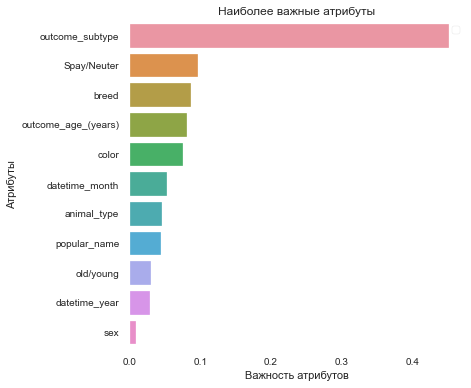

In [155]:
headers = list(X_train_22.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()

Есть большой вопрос о необходимости включения признака outcome_subtype в модель. Точнее известен ли этот признак нам заранее или выясняется в момент выуска животного.

In [157]:
model.predict_proba(X_test_22)

array([[0.08, 0.  , 0.  , 0.  , 0.92, 0.  ],
       [0.  , 0.01, 0.02, 0.  , 0.97, 0.  ],
       [0.62, 0.  , 0.  , 0.38, 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.99, 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.14, 0.  , 0.  , 0.86, 0.  , 0.  ]])